This week we'll go for various advice on doing feature engineering, supervised learning and pipelined systems.

Oftentimes, we'll be wondering what to do after we evaluate our algorithm and discover its performance. Should we:

1) Gather more data?

2) Research on more features?

3) Reduce the features?

4) Make the model more complex?

5) Reduce the model complexity?

For this week, we'll be using Santander data from Kaggle. It has a $60000 prize! For our case, it's a much larger dataset than what we've handled before, plus, in my opinion, it's doable.

First, we'll review the bias-variance tradeoff and what it means in terms of the training loss and the cross validation loss.

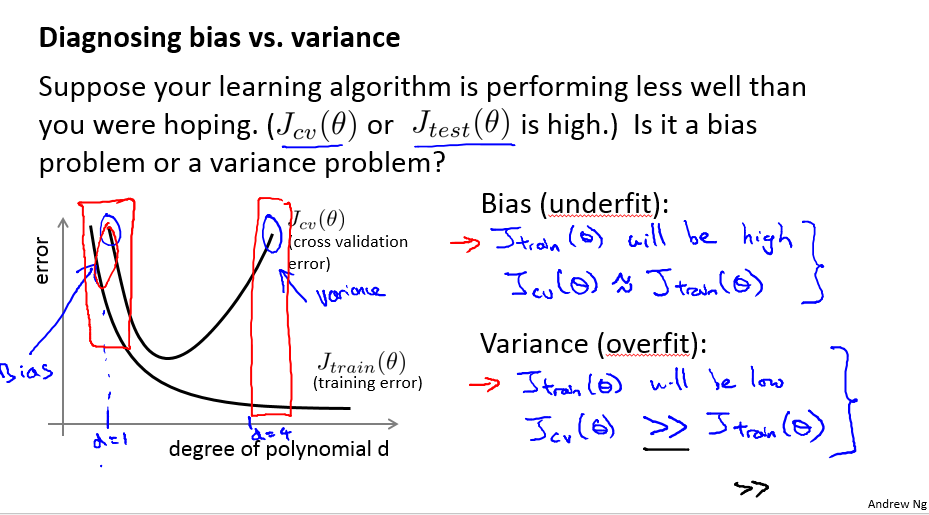

In [5]:
from IPython.display import display, Image
display(Image("images/bias_variance.png"))

# Addressing Overfitting: Regularization
For gradient-based methods (Logistic regression, SVM, neural networks) High variance could be addressed with regularization techniques. Recall the L1 (lasso) and L2 (ridge) regularization:

$$J_{reg}(\theta,y) = \frac{1}{2} \sum_{i=0}^{m}(h_\theta(x^{(i)}) - y^{(i)}) + \alpha\sum_{i=1}^{n} ||\theta_j||$$

<center>------Or------</center>

$$J_{reg}(\theta,y) = \frac{1}{2} \sum_{i=0}^{m}(h_\theta(x^{(i)}) - y^{(i)}) + \alpha\sum_{i=1}^{n} \theta_j^2$$

For decision trees, high variance is the maximum tree length or the degree of pruning done. For random forests, it is the depth of each tree as well as the number of trees.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import feature_selection as select
from sklearn import preprocessing as prep
from sklearn import pipeline, metrics
from sklearn import cross_validation as cv
%matplotlib inline

/home/dylan/GitHub/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from sklearn import svm
def optimize_svm(X, y):
    hidden_units = 10
    rbf_svc_1 = svm.SVC(kernel='rbf', gamma=0.7, C=1e-2).fit(X, y)
    rbf_svc_2 = svm.SVC(kernel='rbf', gamma=0.7, C=1e-1).fit(X, y)
    rbf_svc_3 = svm.SVC(kernel='rbf', gamma=0.7, C=1).fit(X, y)
    rbf_svc_4 = svm.SVC(kernel='rbf', gamma=0.7, C=1e1).fit(X, y)
    rbf_svc_5 = svm.SVC(kernel='rbf', gamma=0.7, C=1e2).fit(X, y)
    rbf_svc_6 = svm.SVC(kernel='rbf', gamma=0.7, C=1e3).fit(X, y)

    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # title for the plots
    titles = ['RBF SVM C=1e-2', 'RBF SVM C=1e-1', 'RBF SVM C=1', 
              'RBF SVM C=1e1', 'RBF SVM C=1e2', 'RBF SVM C=1e3',]

    plt.figure(figsize=(20,20))
    for i, clf in enumerate((rbf_svc_1, rbf_svc_2, rbf_svc_3,
                             rbf_svc_4, rbf_svc_5, rbf_svc_6)):
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        plt.subplot(3, 2, i + 1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

        # Plot also the training points
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        plt.title(titles[i])

    plt.show()

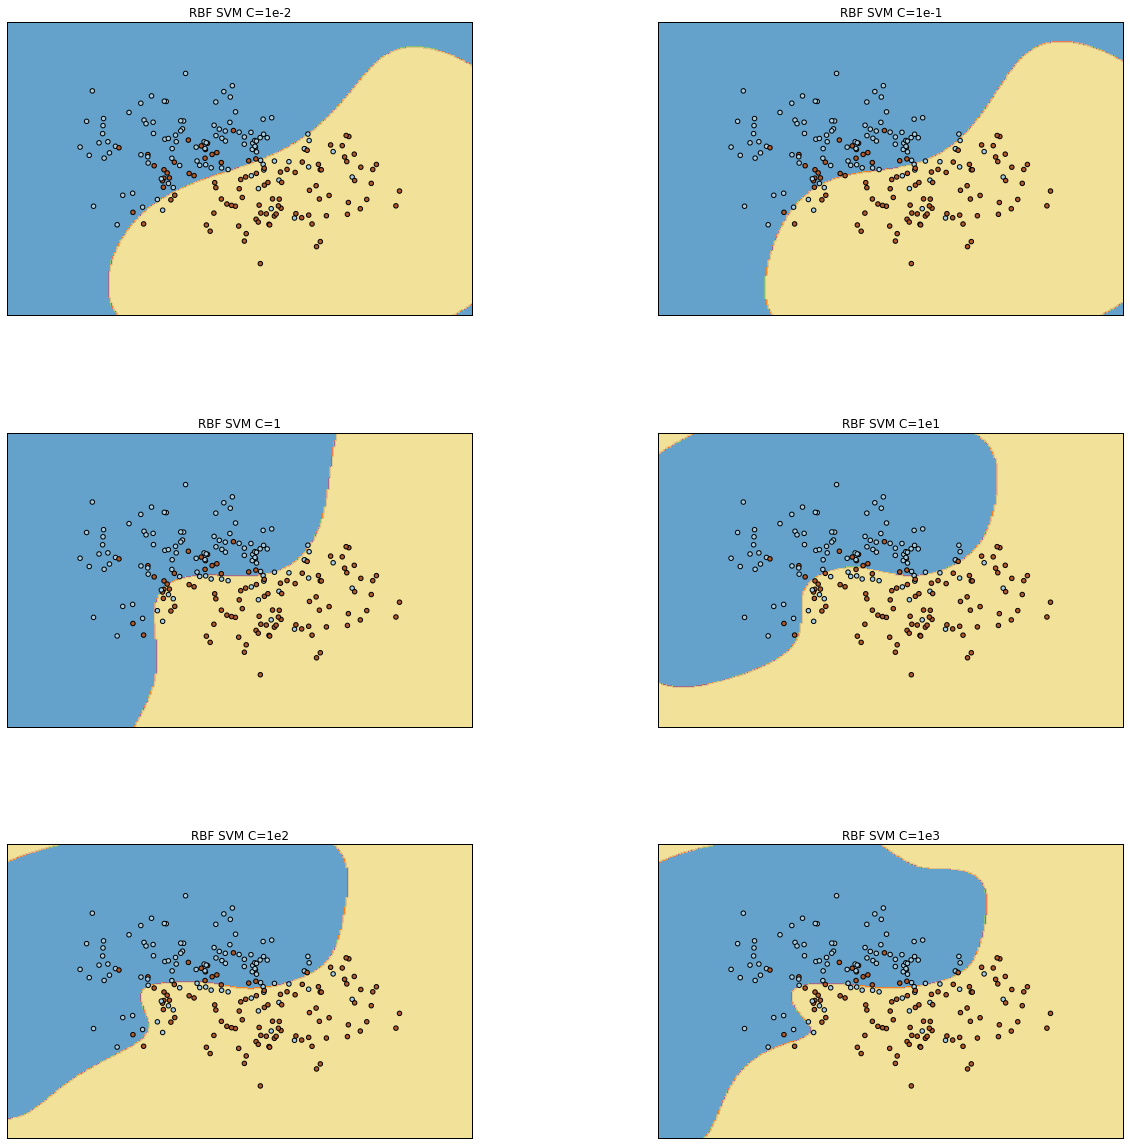

In [4]:
from sklearn import datasets
moon_dataset = datasets.make_moons(n_samples=200, noise=0.5, random_state=1)
X_moon = np.asarray(moon_dataset[0])
y_moon = np.asarray(moon_dataset[1])
optimize_svm(X_moon,y_moon)

In [2]:
data = pd.read_csv("data/train-santander.csv")
X_orig = data.drop(['TARGET','ID'], axis=1)
y_orig = data['TARGET']
X_train, X_test, \
    y_train, y_test = cv.train_test_split(X_orig, y_orig, 
                                          test_size=0.33)
X_train = X_train.fillna(0).as_matrix()
X_test = X_test.fillna(0).as_matrix()
y_train = y_train.as_matrix()
y_test = y_test.as_matrix()


# get subset so the run for the next experiments are faster
rows = np.random.choice(X_train.shape[0],10000, replace=False)
X_sub = X_train[rows]
y_sub = y_train[rows]

test_rows = np.random.choice(X_test.shape[0],10000, replace=False)
X_sub_test = X_test[test_rows]
y_sub_test = y_test[test_rows]

## Variance Thresholds 
Note: just a side note, let's remove the features whose values never change. This is a common feature engineering step before anything even starts.

Feature selection involves choosing the optimum number of features according to some criterion. We'll start with a basic variance threshold. 

In [6]:
variances = np.var(X_sub, axis=0)

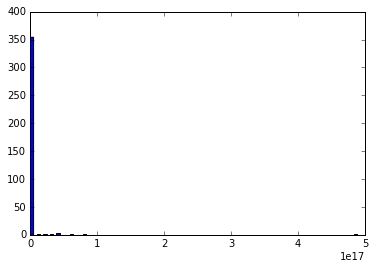

In [7]:
num_bins = 100
plt.hist(variances, num_bins)
plt.show()

In [24]:
from sklearn import feature_selection as select
var_trans = select.VarianceThreshold()
var_trans.fit_transform(X_sub).shape

(10000, 293)

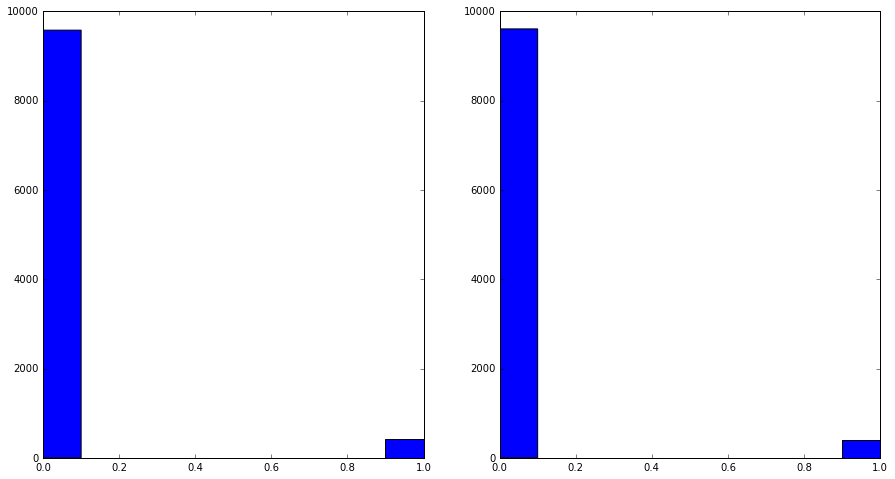

In [9]:
fig, axes = plt.subplots(1,2,figsize=(15,8))
axes[0].hist(y_sub)
axes[1].hist(y_sub_test)
plt.show()

In [23]:
X_norm = var_trans.fit_transform(X_sub)

## Regularization strength
You can graph regularization strength and see the optimum point where the training and CV error diverges considerably. 

### Q: Try out different values for C and see how the AUC and logistic loss metrics vary. Do cross validation=3.

### AUC Metric

In [ ]:
# then normalize since log res can converge faster!
scaler = prep.StandardScaler()
X_scaled_sub = scaler.fit_transform(X_norm)

In [ ]:
from sklearn import linear_model
from sklearn import cross_validation as cv
reg = [0.001, 0.03, 0.01, 0.3, 0.1, 1.0, 3.0, 10, 30, 100]

overall_cv_scores = []
overall_cv_std = []
overall_train_scores = []
overall_train_std = []
for strength in reg:
    logres = linear_model.LogisticRegression(C=strength)
    skf = cv.StratifiedKFold(y_sub, n_folds=10)
    cv_scores = []
    cv_std = []
    train_scores = []
    train_std = []
    for train_index, test_index in skf:
        X_train_fold, X_test_fold =\
            X_scaled_sub[train_index], X_scaled_sub[test_index]
        y_train_fold, y_test_fold =\
            y_sub[train_index], y_sub[test_index]
        logres.fit(X_train_fold, y_train_fold)
        preds_train= logres.predict(X_train_fold)
        train_scores.append(
            metrics.roc_auc_score(y_train_fold, preds_train))
        preds_test = logres.predict(X_test_fold)
        cv_scores.append(
            metrics.roc_auc_score(y_test_fold, preds_test))
    # END CROSS VALIDATION
    overall_train_scores.append(np.mean(train_scores))
    overall_train_std.append(np.std(train_scores))
    overall_cv_scores.append(np.mean(cv_scores))
    overall_cv_std.append(np.std(cv_scores))

In [ ]:
ax = plt.subplot(111)
ax.errorbar(reg, overall_train_scores, yerr=overall_train_std,
            fmt='-x',c="blue", label="Train AUC")
ax.errorbar(reg, overall_cv_scores, yerr=overall_cv_std,
            fmt='-o',c="red", label="CV AUC")
ax.set_xscale('log')
ax.legend()

###  Logistic Loss

In [ ]:
from sklearn import linear_model
from sklearn import cross_validation as cv
reg = [0.001, 0.03, 0.01, 0.3, 0.1, 1.0, 3.0, 10, 30, 100]

overall_cv_scores = []
overall_cv_std = []
overall_train_scores = []
overall_train_std = []
for strength in reg:
    logres = linear_model.LogisticRegression(C=strength)
    skf = cv.StratifiedKFold(y_sub, n_folds=10)
    cv_scores = []
    cv_std = []
    train_scores = []
    train_std = []
    for train_index, test_index in skf:
        X_train_fold, X_test_fold =\
            X_scaled_sub[train_index], X_scaled_sub[test_index]
        y_train_fold, y_test_fold =\
            y_sub[train_index], y_sub[test_index]
        logres.fit(X_train_fold, y_train_fold)
        preds_train= logres.predict(X_train_fold)
        train_scores.append(
            metrics.log_loss(y_train_fold, preds_train))
        preds_test = logres.predict(X_test_fold)
        cv_scores.append(
            metrics.log_loss(y_test_fold, preds_test))
    # END CROSS VALIDATION
    overall_train_scores.append(np.mean(train_scores))
    overall_train_std.append(np.std(train_scores))
    overall_cv_scores.append(np.mean(cv_scores))
    overall_cv_std.append(np.std(cv_scores))

In [ ]:
ax = plt.subplot(111)
ax.errorbar(reg, overall_train_scores, yerr=overall_train_std,
            fmt='-x',c="blue", label="Train error")
ax.errorbar(reg, overall_cv_scores, yerr=overall_cv_std,
            fmt='-o',c="red", label="CV error")
ax.set_xscale('log')
ax.legend()

# Learning Curve
The learning curve is helpful to visualize the performance of the algorithm as the number of samples increases. View the following diagrams and convince yourself of the following heuristics:

1) When the CV error and training error never diverges, this means your model is suffering from high bias.

2) When the CV error and training error diverges too much, this means your model is suffering from high variance.

We'll be using sklearn's Pipeline to simplify the creation of piped architectures. It's calling the fit_transform of each element in the pipeline. It can be used for training and testing.

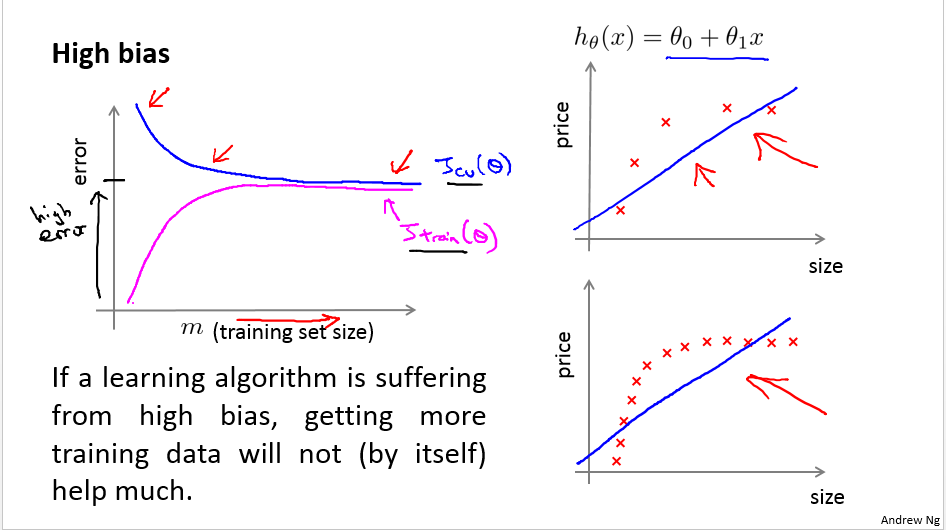

In [45]:
from IPython.display import display, Image
display(Image("images/learning_curve_bias.PNG"))

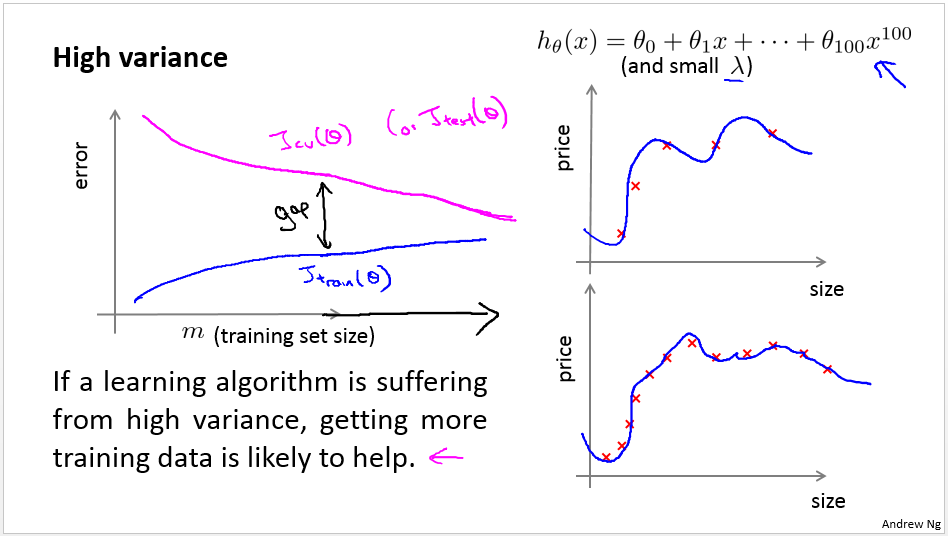

In [46]:
from IPython.display import display, Image
display(Image("images/learning_curve_var.PNG"))

In [50]:
from sklearn import grid_search
from sklearn import cross_validation as cv
from sklearn import linear_model, pipeline
from time import time
pipe = pipeline.Pipeline([
    ('remover', select.VarianceThreshold()),
    ('scaler', prep.StandardScaler()),
    ('logres', linear_model.LogisticRegression())
])

/home/dylan/GitHub/scikit-learn/sklearn/grid_search.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [ ]:
from sklearn import learning_curve
train_sizes_abs, train_scores, test_scores =\
    learning_curve.learning_curve(pipe, X_sub, y_sub, cv=10,
    train_sizes=np.linspace(0.1,1.0, num=10), scoring="log_loss")

In [ ]:
mean_train = [np.mean(abs(v)) for v in train_scores]
abs_dev_train = [np.std(v) for v in train_scores]
ax = plt.subplot(111)
ax.errorbar(train_sizes_abs, mean_train, yerr=abs_dev_train, fmt='-o', label="Train error")
mean_test = [np.mean(abs(v)) for v in test_scores]
abs_dev_test = [np.std(v) for v in test_scores]
ax.errorbar(train_sizes_abs, mean_test, yerr=abs_dev_test, fmt='-o', label="Test error")
ax.set_xlabel("Number of samples")
ax.set_ylabel("Log Loss")
plt.title("Mean of loss")
plt.legend()
plt.show()

# Error Analysis
Error analysis is crucial to understanding what's next.<b> Not all errors are created equal</b>. We will explore the different types of metrics that can shed light to what's going wrong.

## Precision & Recall
Precision & recall came from information retrieval literature and is a binary metric. Precision means the percentage of true positives from retrieved instances. Recall means the percentage of true positives from relevant instances. For a visual representation, view the following image.

In [48]:
from IPython.display import display, Image
display(Image(url=\
              "https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png"))

F-Score measures the harmonic mean between the two. This is relevant since the harmonic mean is the most pessimistic of the three means, and will reflect on any weaknesses on any of the two.

Lastly, to bring the precision, recall, f-score metrics to multiclass problems, you could make it one-against-all, and see how the current model performs with each class.

In [51]:
pipe.fit(X_sub, y_sub)
predictions = pipe.predict(X_sub_test)

In [52]:
print(metrics.classification_report(y_sub_test, predictions))

             precision    recall  f1-score   support

          0       0.96      1.00      0.98      9608
          1       0.13      0.01      0.01       392

avg / total       0.93      0.96      0.94     10000



## Confusion matrix
Confusion matrices represent evaluations of multiclass problems by presenting a mxm matrix, with m being the number of classes.

In [53]:
metrics.confusion_matrix(y_sub_test, predictions)

array([[9588,   20],
       [ 389,    3]])

Combined, these analyses reveal the following observations:

1) There seems to be a large number of class 0 that are very much alike that can simply be classified.

2) Recognizing class 1 requires a nonlinear solution, because of low precision and high recall.

# Imbalanced Datasets: Methodologies
Some algorithms can tolerate imbalance by adding a weight to each sample. In particular, gradient-based methods benefit from this out-of-the-box. Decision trees, (C4.5) benefit from class weights by its internal pruning algorithm. Other algorithms are not so lucky. Here are some out-of-algorithm methods to deal with class imbalance.

1) Get more data.

2) Oversample or undersample.

3) Synthesize additional data.

4) If your model outputs probabilities, you always adjust the threshold based on the ROC curve. Simply point to the desired false positive rate and you're good to go.

5) Try another approach. If your target variable is so rare, then perhaps outlier analysis ais the way to go.

## Sample weighting
We can "equalize" the weight of the rare class to be equal to the other classes by setting a parameter in sklearn. Recall the cost function.

$$
J(\theta,y) = \frac{1}{m}\sum_{i=0}^{m}\eta(y) y^{(i)} log(h_\theta(x^{(i)})) + (1-y^{(i)})log(1- h_\theta(x^{(i)}))
$$

Each sample is weighted equally. If we add a weight for the positive classes, then we can fix the effects of an unbalanced dataset.

In [54]:
pipe

Pipeline(steps=[('remover', VarianceThreshold(threshold=0.0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logres', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [55]:
from sklearn import cross_validation as cv
from sklearn import linear_model
ks = [45, 55, 65, 75, 85, 95]

print("No sample weights")
pipe.set_params(logres__class_weight=None)
print(cv.cross_val_score(pipe, X_sub, y_sub, scoring="log_loss"))
pipe.fit(X_sub, y_sub)
predictions = pipe.predict(X_sub_test)
print(metrics.classification_report(y_sub_test, predictions))

print("Balanced sample weights")
pipe.set_params(logres__class_weight="balanced")
print(cv.cross_val_score(pipe, X_sub, y_sub, scoring="log_loss"))
pipe.fit(X_sub, y_sub)
predictions = pipe.predict(X_sub_test)
print(metrics.classification_report(y_sub_test, predictions))

print("Class 1 has 1000x the cost!")
pipe.set_params(logres__class_weight={1:1000})
print(cv.cross_val_score(pipe, X_sub, y_sub, scoring="log_loss"))
pipe.fit(X_sub, y_sub)
predictions = pipe.predict(X_sub_test)
print(metrics.classification_report(y_sub_test, predictions))

No sample weights
[-0.1563234  -0.15374126 -0.17171198]
             precision    recall  f1-score   support

          0       0.96      1.00      0.98      9608
          1       0.13      0.01      0.01       392

avg / total       0.93      0.96      0.94     10000

Balanced sample weights
[-0.53636887 -0.5118634  -0.57756758]
             precision    recall  f1-score   support

          0       0.98      0.73      0.83      9608
          1       0.09      0.67      0.16       392

avg / total       0.95      0.72      0.81     10000

Class 1 has 1000x the cost!
[-2.58683416 -2.53304679 -2.6444257 ]
             precision    recall  f1-score   support

          0       0.98      0.16      0.27      9608
          1       0.04      0.94      0.08       392

avg / total       0.95      0.19      0.27     10000



# Big data
Big data has three facets, veracity, volume and velocity. As a data scientist, you should learn how to cover all three. For volume, we have the options of reducing n (feature selection) and m (stochastic methods).


## Stochastic and Mini-Batch Gradient Descent 
When you hear the word "stochastic" it usually involves a random sampling instead of using the entire dataset for one iteration / epoch / fitting. It turns out that some algorithms can scale to millions of samples if it uses stochastic gradient descent.

Batch gradient descent on the other hand, uses small batches to compute the gradients.

In [56]:
from IPython.display import display, Image
display(Image(url=\
              "https://43284bdcf41602d9ee3b7f9155623bc4db1a5d55.googledrive.com/host/0B56ak7W-HmqASVBYZTJ1WXVoQUU/img/stochastic.png"))

In [57]:
from IPython.display import display, Image
display(Image(url=\
              "https://i.ytimg.com/vi/U-4XvK7jncg/hqdefault.jpg"))

# Feature Selection
Feature selection is an important step in machine learning. Not all features are useful, and oftentimes, if we use smaller features, we can "reduce the noise" in the data and give our model an easier time fitting the data. One selection algorithm available to us is Chi2. It is a statistic that measures the <b>independence</b> of the class variable to another variable. 

## Select by Chi2
The chi-square metric could be used for feature selection. We could remove "uncorrelated" features with respect to a target variable. Some rules though:

1) X must non be non-negative

2) X must be numerical

3) This approach needs the target variable.

Lastly, feature selection introduces <b>bias</b> into the system.

$$
X_{new} = \frac{X_{old} - \mu}{\sigma}
$$

In [3]:
remover = select.VarianceThreshold()
scaler = prep.StandardScaler()
ranger= prep.MinMaxScaler()
pipe = pipeline.Pipeline([("remover", remover),("scaler", scaler), ("ranger", ranger)])
X_train_norm = pipe.fit_transform(X_train,y_train)
print("X_sub_norm: {}".format(X_train_norm.shape))

X_sub_norm: (50933, 322)


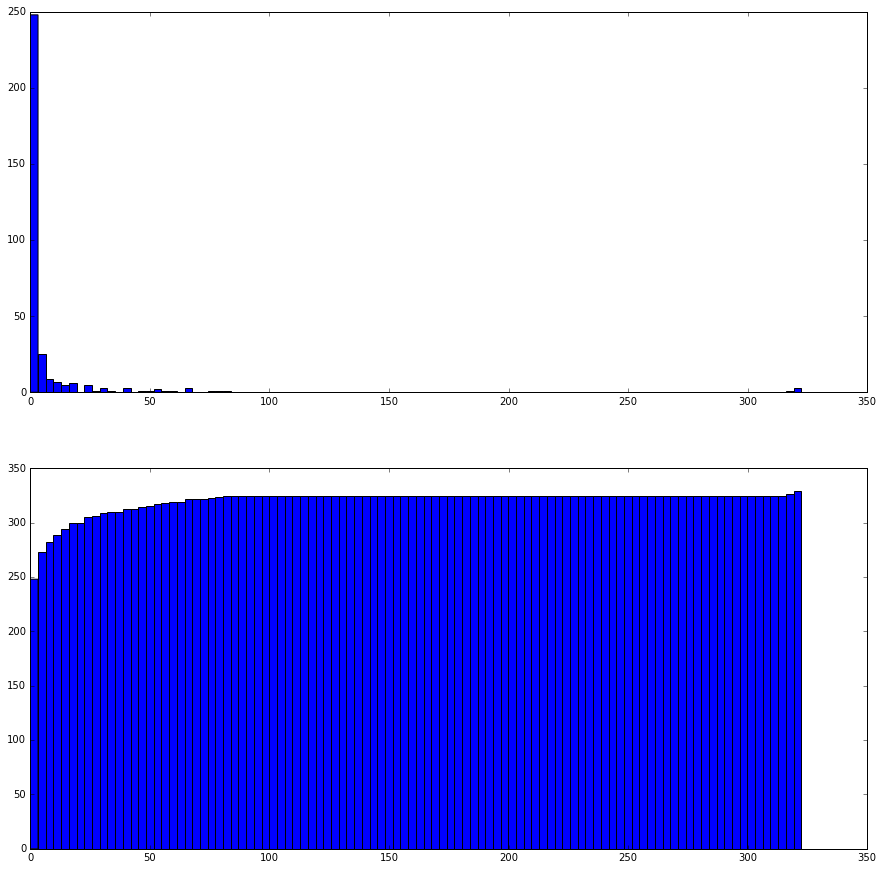

In [60]:
ch,pval = select.chi2(X_train_norm, y_train)
# TODO: another plot for the actual histogram
fig, axes = plt.subplots(2,1, figsize=(15,15))
axes[0].hist(ch[~np.isnan(ch)], bins=100)
axes[1].hist(ch[~np.isnan(ch)], cumulative=True, bins=100)

plt.show()

In [62]:
# remove useless features

# Standardize using scaler
from sklearn import preprocessing
preprocessing.StandardScaler()

# Use MinMax Ranger
ranger = preprocessing.MinMaxScaler()

# Select percentile that you want
from sklearn import feature_selection as select

# use X_sub_train as your train_set
# ranger.fit_transform(TRAIN_SET, Y_TRAIN_SET)
#### IF PIPE
# pipe.fit_transform(TRAIN_SET,Y_TRAIN_SET)

# use X_sub_test as your test set
#remover.fit(TEST_SET,Y_TEST)
#scaler.fit(TEST_SET,Y_TEST)
#ranger.fit(TEST_SET,Y_TEST)
#### If PIPE
# pipe.fit(TEST_SET,Y_TEST)

# use class_weight="balanced" in logistic regression

# predictions = logres.predict(X_sub_test)
# do classification report
# metrics.classification_report(y_sub_test, y_predicted)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [61]:
k = 90
selector = select.SelectPercentile(score_func=select.chi2, 
                                   percentile=k)
selector.fit_transform(X_train_norm, y_train).shape

(50933, 296)

As you can see, we can reduce the number of features using this technique. However, this is called <b>Univariate feature selection</b> since it only takes into account features one at a time. Aggressive reduction may prove bad for generalization.

Let's use this at once for classification.
### Q: Use different percentiles and logistic regression, and analyze the results.

In [ ]:
from sklearn import cross_validation as cv
from sklearn import linear_model
ks = [45, 55, 65, 75, 85, 95]

for k in ks:
    selector = select.SelectPercentile(percentile=k)
    X_sel = selector.fit_transform(X_train_norm, y_train)
    logres = linear_model.LogisticRegression(class_weight="balanced")
    results = cv.cross_val_score(logres, X_sel, y_train, scoring="log_loss")
    print("Features: {}, mean: {}, error: {}".format(
            X_sel.shape[1],
            np.mean(results),
            np.std(results)))

From this result, it seems reducing the columns is not a significant step. For sanity's sake let's consider the unreduced dataset.

In [ ]:
logres = linear_model.LogisticRegression(class_weight="balanced")
pipe.steps.append(("logres", logres))
results = cv.cross_val_score(logres, X_train_norm, y_train, scoring="log_loss")
print("Features: {}, mean: {}, error: {}".format(
        X_train_norm.shape[1],
        np.mean(results),
        np.std(results)))

## Grid Search
If we want to optimize several hyperparameters at once, then we use the grid search module of sklearn. Here's how to use it.

BTW, <u>vanilla gradient descent</u> will take a long time for 10k+ samples. Recall the algorithm of gradient descent:

$$
\theta_{j} = \theta_j + \alpha \frac{\partial}{\partial\theta_j}J(\theta_j)
$$

The partial derivative is computed by:

$$
\theta_j = \theta_j + \frac{1}{m}\sum_{i=0}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})x_j^{(i)}
$$

Note the summation. The entire dataset is used to compute the gradient for<b> one iteration</b>. This is entirely inefficient, even for convex problems. Thus, we replace this with either <b>Stochastic Gradient Descent</b> or <b>Batch Gradient Descent</b>.

SGD involves replacing the summation with just one example. Batch gradient descent uses a batch size b where b < m.

In [ ]:
X_train, X_test, y_train, y_test = cv.train_test_split(
    X_orig, y_orig, test_size=0.6, random_state=0)
tuned_parameters = [{'penalty': [], 'C': np.logspace(-3, 3, 7),
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

parameters = {
    'logres__C': np.logspace(-3, 3, 7),
    'selector__percentile': (50, 60, 70, 80, 90, 100)
}
grid_search = grid_search.GridSearchCV(
    pipe, parameters, n_jobs=2, verbose=1, scoring="log_loss")

t0 = time()
grid_search.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


# Feature transformation
Feature transformation is the general term for transforming our existing features to either more complicated or simpler representations. Adding polynomial degrees to our features can reduce error due to bias to our supervised learning problem. Simplifying can reduce error due to variance. Principal components analysis can do both.

## Principal Components Analysis
And then lastly, we go to principal components analysis, a method that uses orthogonal transformations to transform the data into a set of linearly uncorrelated variables called principal components. Each principal component forms the basis for the axes that is the direction / vector of the largest possible variance in the data under the constraint that others are orthogonal to it.

In [6]:
display(Image(url=\
              "http://deeplearning.stanford.edu/wiki/images/thumb/5/5b/Pca_2d_basis.png/400px-Pca_2d_basis.png"))

### PCA Steps
To do PCA, we have to get the eigendecomposition of the covariance matrix of the dataset.<b> This operation is O(m^3)</b> as long as n~m.

Step 1: Mean normalization:
$$ x_j^{(i)} = \frac{x_j^{(i)} - \mu_j}{\sigma_j} $$

Step 2: Compute covariance matrix:
$$\sigma_{jk} = \frac{1}{m}\sum_{i=1}^{m}\left(  x_{ij}-\bar{x}_j \right)  \left( x_{ik}-\bar{x}_k \right)$$

or, in matrix form:
$$\Sigma = \frac{1}{m} \left( (\mathbf{X} - \mathbf{\bar{x}})^T\;(\mathbf{X} - \mathbf{\bar{x}}) \right)$$

where 

$$\mathbf{\bar{x}} = \frac{1}{m}\sum\limits_{i=1}^m x_{i}$$

Step 3: Compute the SVD of matrix Sigma. Vector S contains the eigenvalues.

$$ U, S, V = svd(\Sigma) $$

Let's try it!

Credits to Sebastian Raschka (http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html) for the steps.

In [7]:
mean_vec = np.mean(X_train_norm, axis=0)
cov_mat = (X_train_norm - mean_vec).T.dot((X_train_norm - mean_vec)) / (X_train_norm.shape[0]-1)
print('Covariance matrix {}' .format(cov_mat))

Covariance matrix [[  1.62620297e-03  -3.39262348e-05   5.86000400e-07 ...,   1.55409336e-07
    1.99497685e-07   8.90236595e-08]
 [ -3.39262348e-05   1.68300465e-02   4.76964476e-05 ...,   2.07638049e-05
    2.50429911e-05   9.08638375e-06]
 [  5.86000400e-07   4.76964476e-05   6.97159546e-05 ...,   3.54686187e-07
    5.47123815e-07  -2.21890245e-08]
 ..., 
 [  1.55409336e-07   2.07638049e-05   3.54686187e-07 ...,   3.49877804e-05
    4.13081737e-05   9.63719001e-08]
 [  1.99497685e-07   2.50429911e-05   5.47123815e-07 ...,   4.13081737e-05
    5.30238251e-05   1.01746923e-07]
 [  8.90236595e-08   9.08638375e-06  -2.21890245e-08 ...,   9.63719001e-08
    1.01746923e-07   8.98963565e-05]]


In [8]:
print('NumPy covariance matrix: {}'.format(np.cov(X_train_norm.T)))

NumPy covariance matrix: [[  1.62620297e-03  -3.39262348e-05   5.86000400e-07 ...,   1.55409336e-07
    1.99497685e-07   8.90236595e-08]
 [ -3.39262348e-05   1.68300465e-02   4.76964476e-05 ...,   2.07638049e-05
    2.50429911e-05   9.08638375e-06]
 [  5.86000400e-07   4.76964476e-05   6.97159546e-05 ...,   3.54686187e-07
    5.47123815e-07  -2.21890245e-08]
 ..., 
 [  1.55409336e-07   2.07638049e-05   3.54686187e-07 ...,   3.49877804e-05
    4.13081737e-05   9.63719001e-08]
 [  1.99497685e-07   2.50429911e-05   5.47123815e-07 ...,   4.13081737e-05
    5.30238251e-05   1.01746923e-07]
 [  8.90236595e-08   9.08638375e-06  -2.21890245e-08 ...,   9.63719001e-08
    1.01746923e-07   8.98963565e-05]]


In [9]:
np.testing.assert_array_almost_equal(cov_mat, np.cov(X_train_norm.T))

In [10]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs[:10])
print('\nEigenvalues \n%s' %eig_vals[:10])

Eigenvectors 
[[  1.78699325e-03+0.j  -3.28861268e-04+0.j   6.98774769e-04+0.j ...,
   -2.99830607e-16+0.j  -1.69076182e-16+0.j  -9.92465136e-32+0.j]
 [  1.26523728e-02+0.j   3.59960670e-02+0.j   8.22939067e-02+0.j ...,
   -3.13433184e-16+0.j   2.86471507e-16+0.j   4.44928137e-20+0.j]
 [  4.05488380e-04+0.j   2.83097986e-04+0.j   5.41103870e-04+0.j ...,
    3.70559845e-15+0.j  -3.09536689e-15+0.j   7.47798506e-19+0.j]
 ..., 
 [  8.25656413e-05+0.j   2.35367036e-04+0.j  -3.34232797e-05+0.j ...,
    7.64696644e-04+0.j  -7.64792542e-05+0.j   3.01831938e-18+0.j]
 [  8.53447135e-05+0.j   3.02249554e-04+0.j  -3.63428131e-05+0.j ...,
    2.41625108e-04+0.j   7.64639675e-06+0.j  -2.44795866e-18+0.j]
 [  4.30537458e-04+0.j   1.50496793e-03+0.j   6.32809113e-05+0.j ...,
   -3.23496965e-04+0.j  -2.30082651e-04+0.j  -3.50050380e-18+0.j]]

Eigenvalues 
[ 0.80322854+0.j  0.55428231+0.j  0.29032972+0.j  0.23681072+0.j
  0.19027254+0.j  0.18210826+0.j  0.10638785+0.j  0.08133490+0.j
  0.04649194+0.j  

Another implementation for PCA is using SVD, which is actually what is used internally in sklearn's PCA. ;)

In [11]:
u,s,v = np.linalg.svd(cov_mat)
print('Eigenvectors \n%s' %u[:10])
print('\nEigenvalues \n%s' %s[:10])

Eigenvectors 
[[ -1.78699325e-03   3.28861268e-04  -6.98774769e-04 ...,  -4.76520407e-16
   -1.15599182e-21   1.30451205e-15]
 [ -1.26523728e-02  -3.59960670e-02  -8.22939067e-02 ...,  -2.90394799e-17
   -7.63069929e-20  -2.37047538e-15]
 [ -4.05488380e-04  -2.83097986e-04  -5.41103870e-04 ...,   3.92338016e-15
    1.56801496e-18   8.00290560e-14]
 ..., 
 [ -8.25656413e-05  -2.35367036e-04   3.34232797e-05 ...,   4.61486518e-05
   -1.16526914e-18  -2.70097576e-02]
 [ -8.53447135e-05  -3.02249554e-04   3.63428131e-05 ...,  -2.55077859e-05
   -2.09117953e-18  -1.19697619e-03]
 [ -4.30537458e-04  -1.50496793e-03  -6.32809113e-05 ...,  -1.63644480e-06
   -8.15427694e-19   1.61575232e-02]]

Eigenvalues 
[ 0.80322854  0.55428231  0.29032972  0.23681072  0.19027254  0.18210826
  0.10638785  0.0813349   0.04649194  0.03946064]


The matrix U are your eigenvectors and is used to rotate your data. Like so:

$$ x_{new} = U_{1:k}^T X_{old} $$

And this my friends is PCA. In sklearn here it is:

In [12]:
X_train_norm.shape

(50933, 322)

In [13]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_norm)

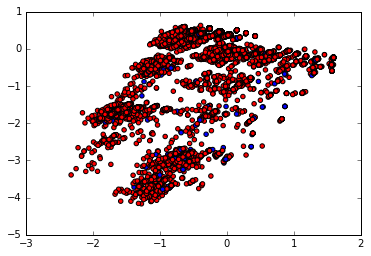

In [22]:
colormap = {0:'red',1:'blue'}

plt.scatter(X_train_pca[:,0], X_train_pca[:,1], 
            c=map(lambda x:colormap[x], y_train),)

In [23]:
for ev in pca.components_:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

Everything ok!


In [29]:
pca = decomposition.PCA(n_components=0.999)
X_train_pca = pca.fit_transform(X_train_norm)
X_train_pca.shape

(50933, 111)

In [ ]:
[0.9, 0.95, 0.99, 0.995, 0.999, 0.9995]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


(array([ 314.,    2.,    3.,    1.,    0.,    0.,    1.,    0.,    0.,    1.]),
 array([ -2.14398399e-17,   8.03228557e-02,   1.60645711e-01,
          2.40968567e-01,   3.21291423e-01,   4.01614279e-01,
          4.81937134e-01,   5.62259990e-01,   6.42582846e-01,
          7.22905701e-01,   8.03228557e-01]),
 <a list of 10 Patch objects>)

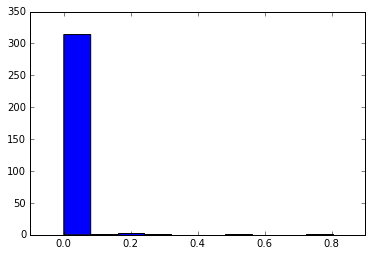

In [25]:
plt.hist(np.float32(eig_vals))

## Q: Did it help? Try it!

In [31]:
from sklearn import pipeline, linear_model
pipe_no_pca = pipeline.Pipeline([
    ('remover', select.VarianceThreshold()),
    ('scaler', prep.StandardScaler()),
    ('logres', linear_model.LogisticRegression(class_weight="balanced"))
])

pipe_with_pca = pipeline.Pipeline([
    ('remover', select.VarianceThreshold()),
    ('scaler', prep.StandardScaler()),
    ('pca', decomposition.PCA()),
    ('logres', linear_model.LogisticRegression(class_weight="balanced"))
])

pipe_whiten = pipeline.Pipeline([
    ('remover', select.VarianceThreshold()),
    ('scaler', prep.StandardScaler()),
    ('pca', decomposition.PCA(whiten=True)),
    ('logres', linear_model.LogisticRegression(class_weight="balanced"))
])

In [32]:
pipe_no_pca.fit(X_train, y_train)

Pipeline(steps=[('remover', VarianceThreshold(threshold=0.0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logres', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [33]:
pipe_with_pca.fit(X_train, y_train)

Pipeline(steps=[('remover', VarianceThreshold(threshold=0.0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, n_components=None, whiten=False)), ('logres', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [34]:
pipe_whiten.fit(X_train, y_train)

Pipeline(steps=[('remover', VarianceThreshold(threshold=0.0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, n_components=None, whiten=True)), ('logres', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [35]:
# pipe_no_pca.fit(X_train, y_train)
predictions = pipe_no_pca.predict(X_test)
print("Not PCA {}".format(metrics.classification_report(y_test, predictions)))
print(metrics.confusion_matrix(y_test, predictions))

predictions = pipe_with_pca.predict(X_test)
print("W/ PCA {}".format(metrics.classification_report(y_test, predictions)))
print(metrics.confusion_matrix(y_test, predictions))

predictions = pipe_whiten.predict(X_test)
print("W/ PCA Whitening {}".format(metrics.classification_report(y_test, predictions)))
print(metrics.confusion_matrix(y_test, predictions))

Not PCA              precision    recall  f1-score   support

          0       0.98      0.70      0.81     24115
          1       0.09      0.73      0.16       972

avg / total       0.95      0.70      0.79     25087

[[16760  7355]
 [  265   707]]
W/ PCA              precision    recall  f1-score   support

          0       0.98      0.70      0.81     24115
          1       0.09      0.73      0.16       972

avg / total       0.95      0.70      0.79     25087

[[16760  7355]
 [  265   707]]
W/ PCA Whitening              precision    recall  f1-score   support

          0       0.95      0.59      0.73     24115
          1       0.02      0.24      0.04       972

avg / total       0.91      0.57      0.70     25087

[[14140  9975]
 [  739   233]]


# Submission

In [ ]:
test_data = pd.read_csv("data/test-santander.csv")
X_test_orig = test_data.drop(['ID'], axis=1)
ids = test_data[['ID']].as_matrix()
ids = np.int32(ids)

In [ ]:
pipe.fit(X_train, y_train)

In [ ]:
predictions_test = pipe.predict_proba(X_test_orig)

In [ ]:
submission_1 = np.hstack((ids, predictions_test))
submission_1 = pd.DataFrame(data=submission_1[:,[0,2]],    # get only the values of the positive class
                            index=submission_1[:,0],    # 1st column as index too
                            columns=["ID","TARGET"], dtype=np.float32)
submission_1[["ID"]] = submission_1[["ID"]].astype(int)
submission_1.to_csv('submissions/santander-submission-1.(chi.logres).txt',
                    index=False, dtype={'ID':np.int64, 'TARGET':np.float64})